In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pointprocesses as ppr

In [5]:
import torch

In [6]:
torch.manual_seed(1)

In [7]:
import os
import sys

In [8]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Notebook dir /home/manifold/Documents/etudes


In [9]:
sys.path

['',
 '/home/manifold/Documents/etudes/map511-p3a',
 '/home/manifold/miniconda3/envs/pytorch/lib/python37.zip',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.3.1-py3.7-linux-x86_64.egg',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions',
 '/home/manifold/.ipython',
 '/home/manifold/Documents/etudes']

# Synthetic data, Hawkes processes

The standard Hawkes model has an underlying intensity given by
$$
    \lambda_t = \lambda^0_t + \int_0^t g(t-s)\,dN_s
$$
where the function $g \geq 0$ is called the _kernel_.

Here we simulate Hawkes processes with kernel $g(t) = \alpha\exp(-\delta t)$.

In [10]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [11]:
import itertools
mu = 1.0
tmax = 10.0
alpha = 0.4
beta  = 1.5

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha)))

Expected avg evt no. 16.667


In [12]:
n_traj = 400
sample_trajectories = [ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)) for _ in range(n_traj)]

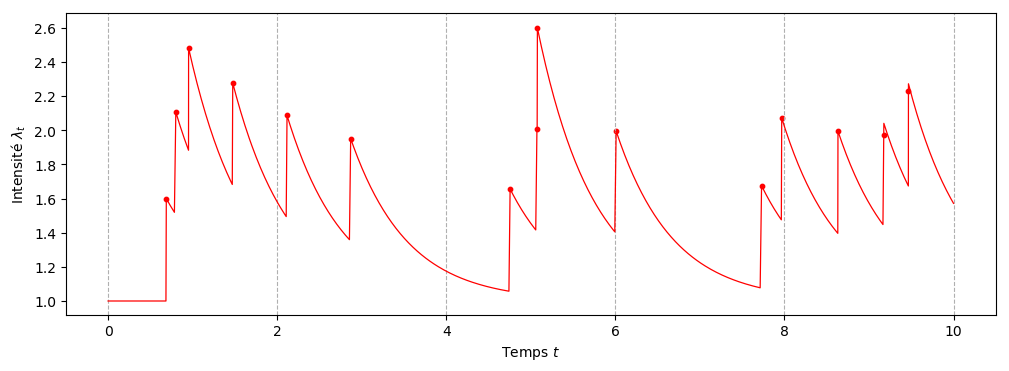

In [13]:
one_traj = sample_trajectories[0]
fig, ax = plt.subplots(1,1, figsize=(12,4), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

In [14]:
print("Number of samples: \t\t%d" % len(sample_trajectories))
seq_lengths = torch.LongTensor([s.shape[0] for s in sample_trajectories])+1
input_size = seq_lengths.max().item()
print("Input size max. traj. length: \t%d" % input_size)
print("tmax = %.3f"  % tmax)
data_array = np.stack([
    np.pad(s[:,0], ((0, input_size - s.shape[0] - 1)), 'constant') for s in sample_trajectories
])
data_tensor = torch.from_numpy(data_array).to(torch.float32)

# Add a beginning-of-sequence event:
data_tensor = torch.cat((torch.zeros(data_tensor.shape[0],1), data_tensor), dim=1)

Number of samples: 		400
Input size max. traj. length: 	36
tmax = 10.000


Text(0, 0.5, 'Number')

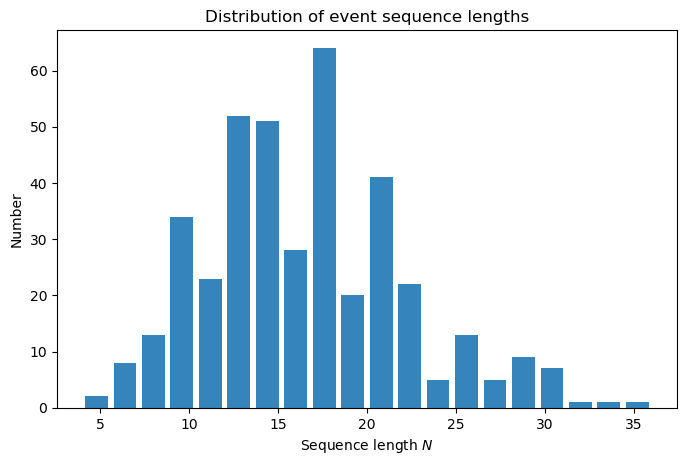

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
ax.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(2/5)), rwidth=0.8, alpha=0.9)
ax.set_title('Distribution of event sequence lengths')
ax.set_xlabel('Sequence length $N$')
ax.set_ylabel('Number')

In [16]:
data_tensor.shape

torch.Size([400, 36])

The first dimension is for time, the second for the sample.

# Neural network

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = \phi\left(W_h h(t)\right)
$$
with $\phi$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i-1}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

The initial values $(h_i)$ are learned recursively by the network.

In [17]:
from torch import nn
import torch.nn.functional as F